<a href="https://colab.research.google.com/github/bdunn20/book_code/blob/main/football_analytics/Ch_4_Multiple_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Chapter 4 - Multiple Regression
## Rushing Yards Over Expected

### Getting ready

In [ ]:
! pip install nfl_data_py
! pip install statsmodels

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 31.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.9/55.9 kB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 93.9 MB/s eta 0:00:00
  Created wheel for nfl_data_py: filename=nfl_data_py-0.3.1-py3-none-any.whl size=13188 sha256=8a43c6f211adc846de70c350a4501a8039ceb05a8c207da862b788c43fd24a31
  Stored in directory: /root/.cache/pip/wheels/ca/2e/d2/4def312ac7c070e1c0002e91ecc6923481a86c3ebd5b2c5413
Successfully built nfl_data_py


In [ ]:
import pandas as pd
import numpy as np
import nfl_data_py as nfl
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
seasons = range(2016, 2023+1)
pbp_py = nfl.import_pbp_data(seasons)

2016 done.
2017 done.
2018 done.
2019 done.
2020 done.
2021 done.
2022 done.
2023 done.
Downcasting floats.


### EDA

In [ ]:
pbp_py_run = pbp_py.query('play_type == "run" & rusher_id.notnull() & down.notnull() & run_location.notnull()').reset_index()
pbp_py_run.loc[pbp_py_run.rushing_yards.isnull(), "rushing_yards"] = 0

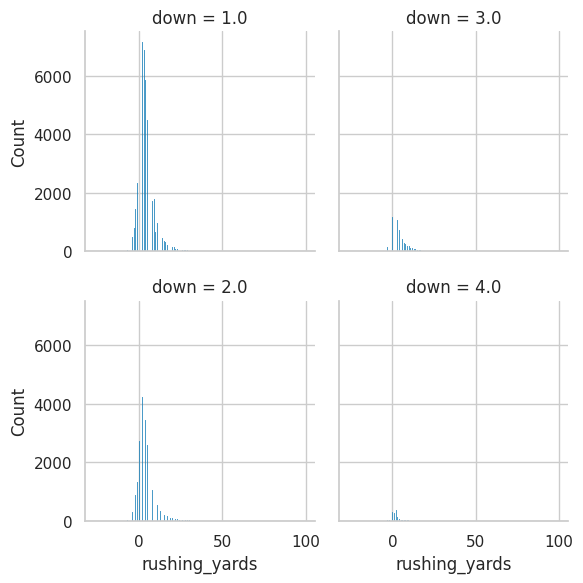

In [ ]:
# histogram for down and rushing yards gained

# change theme
sns.set_theme(style="whitegrid", palette="colorblind")

# change down to be an string
pbp_py_run.down = pbp_py_run.down.astype(str)

# plot rushing yards by down
g = sns.FacetGrid(data=pbp_py_run, col="down", col_wrap=2)
g.map_dataframe(sns.histplot, x="rushing_yards")
plt.show()

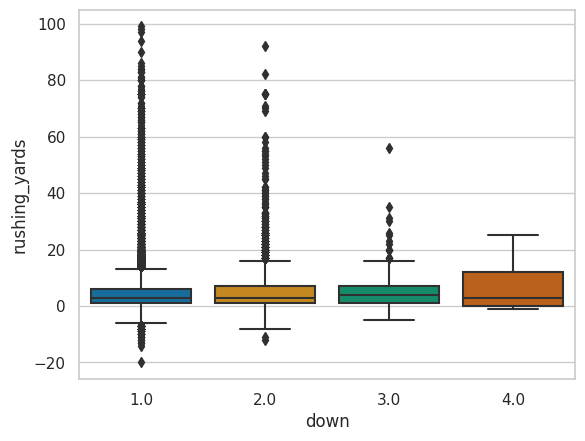

In [ ]:
# isolate to situations where ydstogo is 10
sns.boxplot(data=pbp_py_run.query("ydstogo == 10"), x="down", y="rushing_yards")
plt.show()

This is an example of *Simpson's Paradox*: Including an extra, third grouping variable changes the relationship b/t the two other variables.

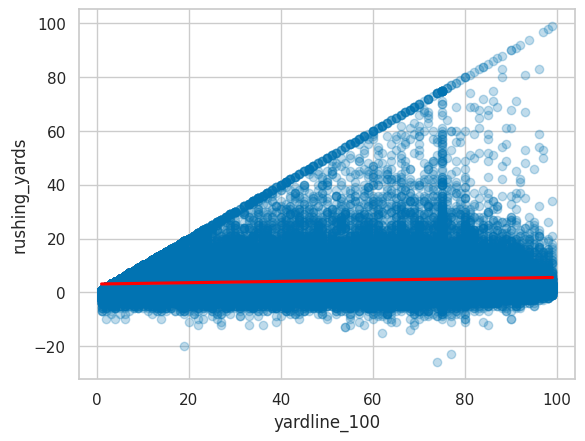

In [ ]:
# lets look at yds to endzone
# scatterplot w/ linear trendline for ball position (ydstogo to the endzone)
# and rushing yards from a play
sns.regplot(
    data=pbp_py_run,
    x="yardline_100",
    y="rushing_yards",
    scatter_kws={"alpha": 0.25}, # change the transparency
    line_kws={"color": "red"} # regression line color
)
plt.show()

In [ ]:
# unclear results above
# bin and avg

pbp_py_run_y100 = pbp_py_run.groupby("yardline_100").agg({"rushing_yards": ["mean"]})

pbp_py_run_y100.columns = list(map("_".join, pbp_py_run_y100.columns))

pbp_py_run_y100.reset_index(inplace=True)

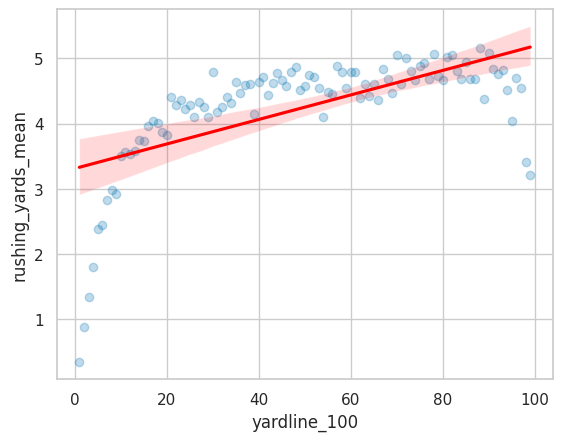

In [ ]:
# scatterplot w/ linear trendline for ball position & rushing yards for data binned by yard
sns.regplot(
    data = pbp_py_run_y100,
    x = "yardline_100",
    y = "rushing_yards_mean",
    scatter_kws = {"alpha": 0.25},
    line_kws = {"color": "red"}
)
plt.show()

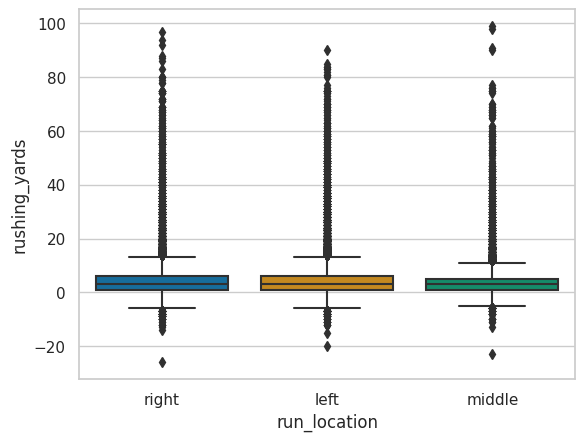

In [ ]:
# boxplot of rushing yards by run location

sns.boxplot(data=pbp_py_run, x="run_location", y="rushing_yards")
plt.show()

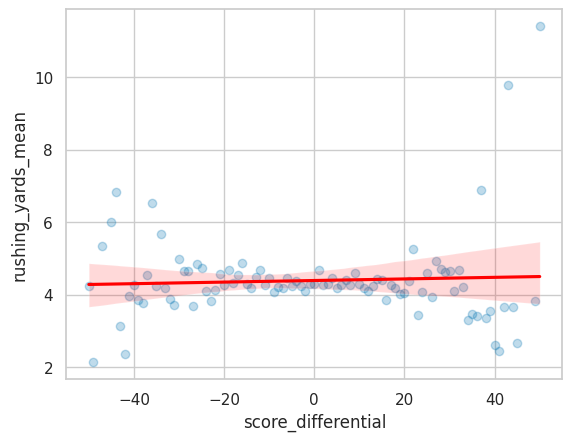

In [ ]:
# scatterplot w/ linear trendline for score differential and
# rushing yards for data binned by score differential

pbp_py_run_sd = pbp_py_run.groupby("score_differential").agg({"rushing_yards": ["mean"]})

pbp_py_run_sd.columns = list(map("_".join, pbp_py_run_sd.columns))

pbp_py_run_sd.reset_index(inplace=True)

sns.regplot(
    data=pbp_py_run_sd,
    x="score_differential",
    y="rushing_yards_mean",
    scatter_kws={"alpha": 0.25},
    line_kws={"color": "red"}
)
plt.show()

### Applying Multiple Linear Regression

In [ ]:
# fit the model & save the residuals

pbp_py_run.down = pbp_py_run.down.astype(str)

expected_yards_py = smf.ols(
    data=pbp_py_run,
    formula="rushing_yards ~ 1 + down + ydstogo + down:ydstogo + yardline_100 + run_location + score_differential")\
    .fit()

pbp_py_run["ryoe"] = expected_yards_py.resid

In [ ]:
# examine the summary of the model

print(expected_yards_py.summary())

                            OLS Regression Results                            
Dep. Variable:          rushing_yards   R-squared:                       0.016
Model:                            OLS   Adj. R-squared:                  0.016
Method:                 Least Squares   F-statistic:                     149.7
Date:                Thu, 30 Nov 2023   Prob (F-statistic):               0.00
Time:                        21:03:01   Log-Likelihood:            -3.2498e+05
No. Observations:               99940   AIC:                         6.500e+05
Df Residuals:                   99928   BIC:                         6.501e+05
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                  1